In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import warnings
warnings.filterwarnings('ignore')

In [89]:
message = pd.read_csv('./data/features.csv')
message = message[(message.date >= '2015-01-01')]

#filtering by family
message = message[(message.store_nbr == 1)&(message.family == 'PRODUCE')]
message = message.reset_index(drop=True)

#handling missing values
message = message.append({'date':'2015-12-25','sales': 0.0,}, ignore_index=True)
message = message.append({'date':'2016-12-25','sales': 0.0}, ignore_index=True)

#set time index
message['date'] = pd.to_datetime(message['date'], format='%Y/%m/%d')
message = message[['date','sales']]
message = message.set_index('date')
message = message.asfreq('D')
message = message.sort_index()

#splitting train and test
train = message.loc[:'2016-12-31']
test = message.loc['2017-01-01':]

test

,sales
date,
2017-01-01,0.0000
2017-01-02,1319.8829
2017-01-03,3558.4360
2017-01-04,4830.2700
2017-01-05,2896.1720
...,...
2017-08-11,1115.3340
2017-08-12,1762.4930
2017-08-13,986.6690


In [84]:
#check stationarity of the data
value = adfuller(message.sales.dropna(), autolag='AIC')
print('Test statistic =',  value[0], '\nCritical value =', value[4], '\nP-value =', value[1])
if value[0] < value[4]['5%']:
    print('Data is stationary')
else:
    print('Data is not stationary')

Test statistic = -2.4513750467107673 
Critical value = {'1%': -3.437363201927513, '5%': -2.864636122077874, '10%': -2.5684185607252137} 
P-value = 0.12775782967092242
Data is not stationary


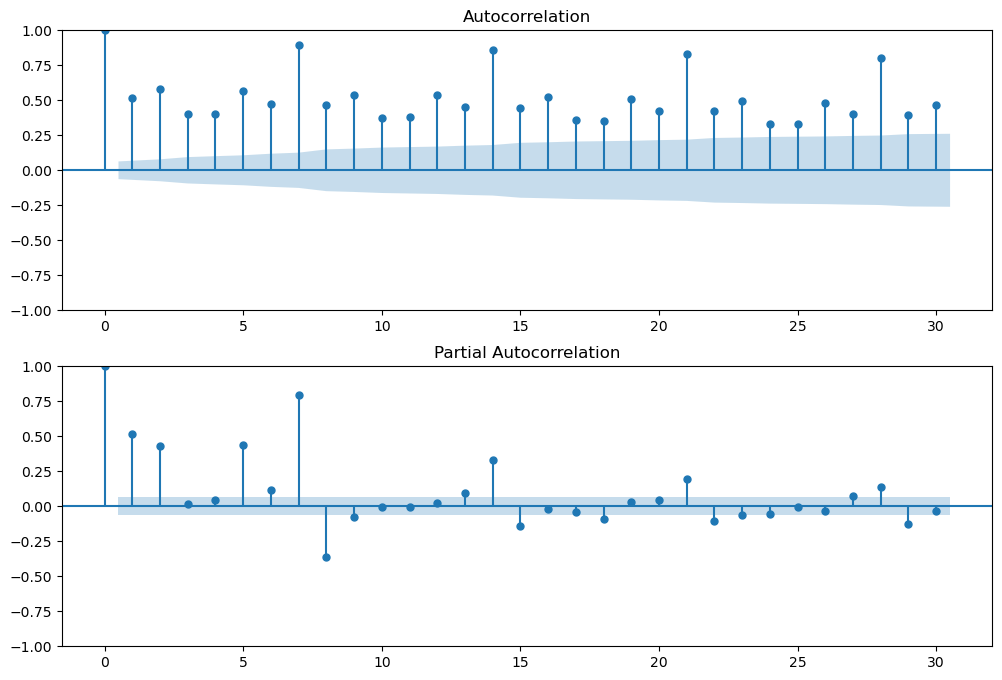

In [85]:
#checking the ACF and PACF plots for seasonality period
fig, ax = plt.subplots(2, figsize=(12,8))
ax[0] = plot_acf(message.sales.dropna(), ax=ax[0], lags=30)
ax[1] = plot_pacf(message.sales.dropna(), ax=ax[1], lags=30)


In [90]:
#transform data to stationary using differencing
message['sales'] = message['sales'].diff().fillna(0)
train['sales'] = train['sales'].diff().fillna(0)
test['sales'] = test['sales'].diff().fillna(0)

message

,sales
date,
2015-01-01,0.000
2015-01-02,2.000
2015-01-03,2.000
2015-01-04,5.000
2015-01-05,-9.000
...,...
2017-08-11,-1146.165
2017-08-12,647.159
2017-08-13,-775.824


In [87]:
#check using the KPSS test
value = kpss(message.sales.dropna(), 'ct')
print('Test statistic =',  value[0], '\nCritical value =', value[3], '\nP-value =', value[1])
if  value[0] < value[3]['5%']:
    print('Data is stationary')
else:
    print('Data is not stationary')

Test statistic = 0.027694155371754292 
Critical value = {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216} 
P-value = 0.1
Data is stationary


In [55]:
#cross validation
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

pdqs = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

temp = []
for i in tqdm(pdq, total=len(pdq)):
    for j in pdqs:
        sarima_model = SARIMAX(train.sales.dropna(), 
                               order = i, 
                               seasonal_order = j, 
                               enforce_invertibility = False, 
                               enforce_stationarity = False
                               )
        
        bic = float(sarima_model.fit().summary().tables[0][3].data[3]) 
        temp.append([i, j, bic])
                
    result = pd.DataFrame(temp, columns=['pdq', 'pdqs', 'bic'])
    result = result.sort_values(by=['bic'],ascending=True)[0:5]

result


  0%|          | 0/27 [00:00<?, ?it/s]

,pdq,pdqs,bic
521,"(2, 0, 1)","(0, 2, 2, 7)",10496.646
62,"(0, 0, 2)","(0, 2, 2, 7)",10499.455
278,"(1, 0, 1)","(0, 2, 2, 7)",10506.070
143,"(0, 1, 2)","(0, 2, 2, 7)",10507.622
80,"(0, 0, 2)","(2, 2, 2, 7)",10508.701


  0%|          | 0/227 [00:00<?, ?it/s]

<Axes: title={'center': 'SARIMAX (RMSE=1817.79)'}, xlabel='date'>

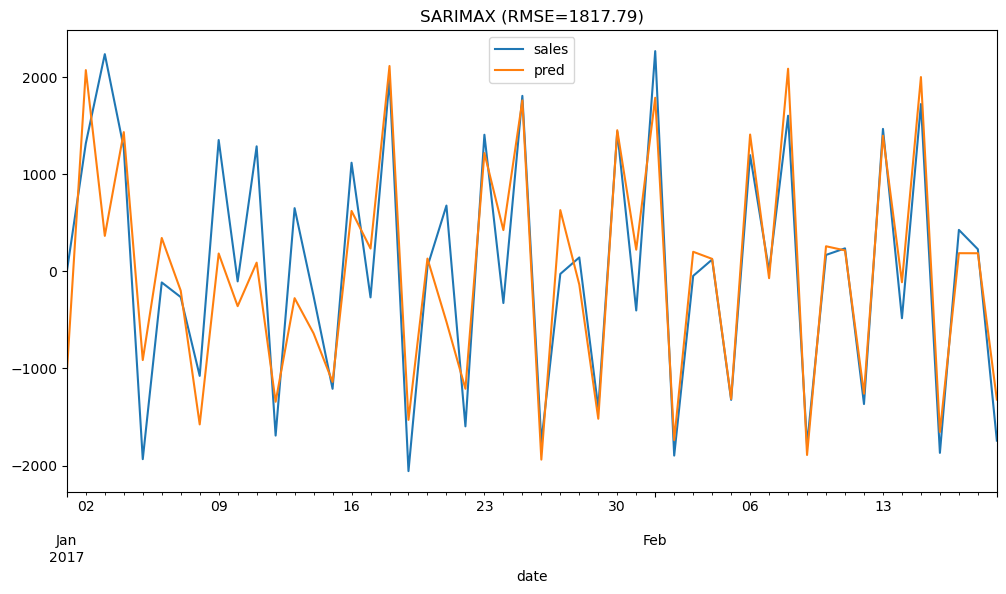

In [91]:
#retrain the model with new data and predict
pred_table = []
for i in tqdm(range(len(test))):
    model = SARIMAX(train.sales.dropna(), order = (2, 0, 1), 
                    seasonal_order = (0, 2, 2, 7), 
                    enforce_invertibility=False, 
                    enforce_stationarity=False)
    
    model = model.fit()
    pred = model.predict(start = test.index[i]- pd.DateOffset(days=7), 
                         end = test.index[i]- pd.DateOffset(days=7)
                        )
    pred_table = pred_table + [pred[0]]
    train = train.append(test.iloc[i:i+1], ignore_index=False)
    
e1 = np.sqrt(np.mean(np.square(test.values - pred_table)))
test['pred'] = pred_table

test[0:50].plot(figsize=(12, 6), title="SARIMAX (RMSE={:0.2f})".format(e1))


In [92]:
test['error'] = abs(test['sales'] - test['pred'])/test['sales']
test

,sales,pred,error
date,,,
2017-01-01,0.0000,-1042.779793,inf
2017-01-02,1319.8829,2073.982809,0.571338
2017-01-03,2238.5531,366.478846,0.836288
2017-01-04,1271.8340,1435.249503,0.128488
2017-01-05,-1934.0980,-912.792983,-0.528052
...,...,...,...
2017-08-11,-1146.1650,398.543948,-1.347720
2017-08-12,647.1590,-212.038447,1.327645
2017-08-13,-775.8240,-1040.335247,-0.340942


In [93]:
#performance
for i in [0.05, 0.1, 0.15, 0.2]:
    value = len(test[test.error < i])/len(test)
    print('\nModel performace at {}%: {}%'.format(i*100, round(value*100,2)))



Model performace at 5.0%: 58.59%

Model performace at 10.0%: 63.88%

Model performace at 15.0%: 69.6%

Model performace at 20.0%: 71.37%


<Axes: >

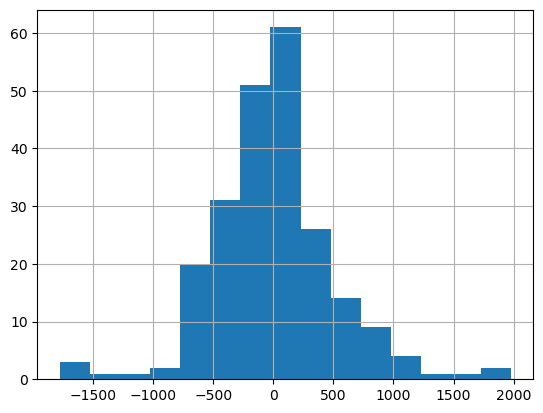

In [94]:
test['error1'] = test['sales'] - test['pred']
test['error1'].hist(bins=15)